# ICFO Challenge: QUANTUM SIMULATION WITH QUANTUM COMPUTERS

Barcelona, April 1-2, 2023

&nbsp;

---

_Greetings, brave heroes! Welcome to the **Qiskit Hackathon Barcelona**._

_Unlike the latest blockbuster on the cinemas right now, the challenges you shall face here are no "mania" jokes.
The nuclear core in our hidden research facilities is destabilized.
Your elite team will venture into the core of our underground advanced lab to deal with this emergency situation (or die trying).
We estimate a maximum of 24h before it collapses and the radioactive debris ruin the world's surface.
Should you succeed, we'll all be safe and you'll be rewarded with great honour.
Should you fail, it'll all be lost!
But fear not, as the power of real quantum computers will be at your fingertips, allowing you to run actual lab experiments on remote IBM Q processors.
With great teamwork no challenge will remain unbeaten._

_The evacuation is nearly complete and most of the big-shots are already heading towards their space shuttles.
Yes, this is the dimension of the potential catastrophe. No pressure, though.
As you head down the facility, contention gates keep shutting down behind you.
At the bottom, you encounter your first challenge: the contention gate leading to the core has already been sealed in what looks like a futile and desperate attempt to contain the disaster._

_The breaching expert in the team gets to work.
However, bypassing this security gate seems more cumbersome than expected.
Just as she seems completely out of options, a wild idea crosses her mind: if you knew the magnetic properties of the security system's board, she would have the perfect tool to alter them and break the gate open._

---

# CONTENTS <a class="anchor" id="0"></a>

* [1. SPINS IN THE GROUND-STATE: THE XXZ HEISENBERG MODEL](#1)
* [2. FERMIONS IN EXCITED STATES: THE LITHIUM HYDRATE MOLECULE](#2)
* [3. MASTER THE QUANTUM SIMULATION SHENANIGANS](#3)
* [REFERENCES](#REF)

---

# 1. SPINS IN THE GROUND STATE: THE XXZ HEISENBERG MODEL <a class="anchor" id="1"></a> [[↑]](#0)

_The quantum physicist in your unit, Seedis, gets to work.
He kneels down and opens the heavy backpack he's been carrying.
It's an actual quantum computer.
"Let's simulate the hell out of it! What're you lookin' at? Chop chop. There's no time to waste!"_

> In this first task, you will study a spin system, a prototypical problem in condensed matter physics. You will find that spins can manifest different phases and behaviours even when they rest at their ground state.

To simulate a quantum system, we need to determine the interactions between the quantum particles that constitute it by defining its Hamiltonian operator.
The security system's board contains rings that follow the XXZ Heisenberg model [[Ref.1]](#REF)<a class="anchor" id="Ref1"></a>, given by

$$ H_{XXZ} = -\frac{1}{4}\sum_{i=1}^N \sigma_i^x\sigma_{i+1}^x + \sigma_i^y\sigma_{i+1}^y + \Delta \, \sigma_i^z\sigma_{i+1}^z \,.$$

Here, $N$ is the number of spin-1/2 particles, $\Delta$ is the anisotropy parameter, and $\sigma^x_i$, $\sigma^y_i$, and $\sigma^z_i$ are Pauli operators, where the subscripts label the qubit they act on.
Furthermore, we impose the periodic boundary condition $\sigma^u_{i+N}=\sigma^u_{i}$ to make the object rest on a ring shape.
Note that only qubits next to each other interact.

This model captures a rich range of behaviours throughout its phase diagram.
First off, for $\Delta=1$, the model converges to the isotropic Heisenberg Hamiltonian (XXX), where all the terms have the same coupling strength.
As we vary $\Delta$, the system can be in three phases:

- $\Delta> 1$: the **ferromagnetic** phase, where all spins point in the same direction.
- $-1<\Delta<1$: the **paramagnetic** or critical phase, where the spins are completely disordered.
- $\Delta<-1$: the **anti-ferromagnetic** phase, where neighboring spins are anti-aligned.

We consider $N=12$ for all the calculations throughout this task, and vary $\Delta$ to see different physics.

## 1.1 - Ground state energy of the XXZ model

Quantum systems can be naturally found in their ground state (GS). 
Thus, the first step is to learn to prepare GSs with the quantum computer.
A prominent approach to do so is through the **Variational Quantum Eigensolver (VQE)** algorithm [[Ref. 2]](#REF)<a class="anchor" id="Ref2"></a>.

Interestingly, the energy spectrum of the $H_{XXZ}$ model can be obtained analytically using the _Bethe ansatz_. For $\Delta>1$, the system is in the _ferromagnetic phase_, in which all the spins in the GS point towards the same direction. This GS energy $\epsilon_{GS}$ is known to be:

$$\epsilon_{GS}=-N\frac{\Delta}{4}\,.$$

### Prepare a simple $N$-qubit state to represent a GS wave function in the ferromagnetic phase. Compute its energy taking the expectation value of the Hamiltonian to confirm the theoretical result $\epsilon_{GS}$ for $\Delta=4$.

> Tip: Qiskit's Heisenberg model implementation already assumes the particles have spin 1/2 and, thus, you do not need to put the 1/4 prefactor in the Hamiltonian definition. Don't forget the sign though!

### Our general approach is based on the property that $\left< YY\right> = - \left< XX \right> \cdot \left< ZZ \right>$, meaning that we will only measure the expecation values of the $ZZ$ and $XX$ coupling terms. To measure the expectation values of the $XX$ terms, we transform to the $Z$-basis by using the Hadamard transform on each qubit.

In [ ]:
from qiskit import QuantumCircuit

num_qubits = 12
Delta = 1

qc_z = QuantumCircuit(12)
qc_x = QuantumCircuit(12)

# If all spins up, otherwise use block command here --------
for qubit in range(num_qubits):
    qc_z.x(qubit)
    qc_x.x(qubit)

# -----------------------------------------------------------

for qubit in range(num_qubits):
    qc_x.h(qubit)

for qc in [qc_z, qc_x]:
    qc.measure_all()

### Here, we use the sampler to obtain the counts.

In [58]:
from qiskit.primitives import Sampler

sampler = Sampler()

job = sampler.run(circuits=[qc_z, qc_x])
results_z = job.result().quasi_dists[0].binary_probabilities()
results_x = job.result().quasi_dists[1].binary_probabilities()

### Last, we convert the counts back to expectation values. For each pair of coupled qubits, we determine the expectation values of $ZZ$ and $XX$ by adding the probabilities for even parities (00 and 11) and subtracting them for odd parities (01 and 10).

In [59]:
def counts_to_expectation_value(results, i1, i2):
    """

    :param results: Count dictionary
    :param i1: index of qubit 1
    :param i2: index of qubit 2
    :return: expectation value
    """
    ev = 0

    for key in results.keys():
            local_key = key[i1]+key[i2]
            if local_key == "00" or local_key == "11":
                ev += results[key]
            else:
                ev -= results[key]

    return ev

ZZs = []
XXs = []
YYs = []

for n in range(num_qubits):

    i1 = n
    i2 = (n + 1) % num_qubits

    ZZs.append(counts_to_expectation_value(results_z, i1, i2))
    XXs.append(counts_to_expectation_value(results_x, i1, i2))

for ZZ, XX in zip(ZZs, XXs):
    YYs.append(XX*ZZ)

### In the end, we find perfect agreement with the exact solution (here for $\Delta=1$).

In [61]:
E_gs = - 1/4 * (sum(XXs) + sum(YYs) + Delta * sum(ZZs))
print(f"Ground state energy: {E_gs}")

Ground state energy: -3.0


### Construct Hamiltonian

In [2]:
from qiskit_nature.second_q.hamiltonians import HeisenbergModel
from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.mappers import LogarithmicMapper
from qiskit.quantum_info import SparsePauliOp

def get_heisenberg_observables(num_qubits=12, delta = 1):

    line_lattice = LineLattice(num_nodes=num_qubits, boundary_condition=BoundaryCondition.PERIODIC)

    model = HeisenbergModel(lattice=line_lattice, coupling_constants=(-1, -1, -delta))
    hamiltonian = model.second_q_op()
    mapper = LogarithmicMapper()
    observables = mapper.map(hamiltonian).primitive

    return observables

    #hamiltonian = model.second_q_op()
    #mapper = LogarithmicMapper()
    #pauli_ops = mapper.map(hamiltonian)

    #return model, pauli_ops

### Create circuits to initialize the ground states

In [3]:
from qiskit import QuantumCircuit

num_qubits = 12

qc_spin_down = QuantumCircuit(num_qubits)
qc_spin_up = QuantumCircuit(num_qubits)

for qubit in range(num_qubits):
    qc_spin_up.x(qubit)

### Here, we extract the $ZZ$ and $XX$ terms, because we do not need to measure the $YY$ terms.

In [4]:
from qiskit.primitives import Estimator

#model = get_heisenberg_model()
#hamiltonian = model.second_q_op()
#mapper = LogarithmicMapper()
observables = get_heisenberg_observables()

paulis, coeffs = observables.paulis.to_labels(), observables.coeffs

paulis_z = [pauli for pauli in paulis if "Z" in pauli]
coeffs_z = [coeffs[paulis.index(pauli)] for pauli in paulis_z]

paulis_x = [pauli for pauli in paulis if "X" in pauli]
coeffs_x = [coeffs[paulis.index(pauli)] for pauli in paulis_z]

observable_z = SparsePauliOp(paulis_z, coeffs_z)
observables_x = [SparsePauliOp(pauli, coeff) for pauli, coeff in zip(paulis_x, coeffs_x)]

estimator = Estimator()

# Exchange here for the other ground state
qc = qc_spin_up

job_z = estimator.run(qc, observable_z)
job_x = estimator.run([qc]*num_qubits, observables_x)

print(f"XX-terms: {job_x.result().values}")

XX-terms: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### We notice that all $\left< X_i X_{i+1}\right>$ terms vanish. Consequently, the same holds for all $\left< Y_i Y_{i+1}\right>$, and we only need the $ZZ$ terms for the final result. We find our result to be in agreement with the exact solution.

In [5]:
e_gs = job_z.result().values[0]
print(f"Ground state energy: {e_gs}")

Ground state energy: -3.0


State preparation is not always that straightforward.
In the _anti-ferromagmetic phase_ (for $\Delta<-1$), the GS wave function is more difficult to prepare, as it consists of a non-trivial superposition of the computational basis states.

In the VQE algorithm, we use a parameterized circuit to prepare the GS of our Hamiltonian.
We start with an initial guess of the circuit parameters and optimize them to minimize the expectation value of the Hamiltonian.
This naturally brings us (close) to the GS of the system, as it is, by definition, the state with the lowest energy.

Before diving into state preparation with VQE, create a baseline to evaluate the variational results.

### Use an exact numerical solver to obtain the GS energy for $\Delta=-2$

In [6]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.ground_state_solvers.ground_state_eigensolver import MinimumEigensolver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

# qubit_converter = QubitConverter(LogarithmicMapper())
numpy_solver = NumPyMinimumEigensolver()

# solver = GroundStateEigensolver(qubit_converter, numpy_solver)

observables = get_heisenberg_observables(delta=-2)

result = numpy_solver.compute_minimum_eigenvalue(operator=observables)

e_gs = result._eigenvalue
# result.__dict__
print(f"Exact ground state energy: {e_gs}")
# hamiltonian_matrix = observables.to_matrix()

Exact ground state energy: -7.4601173755108965


Use the VQE algorithm to prepare the GS of the Hamiltonian for the same value of $\Delta$.
You should try to achieve the closest estimate to the actual GS energy using an **ansatz consisting of three layers of single- and two-qubit gates, where two-qubit gates connect only near neighbor qubits**.
Furthermore, among the different possibilities for the optimizers that you can choose from, use the **Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html)) optimizer**.

### Use the VQE algorithm to estimate the GS energy for $\Delta=-2$

In [7]:
from qiskit.circuit.library import EfficientSU2, TwoLocal

entanglement = "circular"
reps = 3

# ansatz = EfficientSU2(num_qubits, entanglement=entanglement, reps=3).decompose()
#initial_state = QuantumCircuit(num_qubits)
#for n in range(num_qubits):
#    #if n % 2 == 0:
#    #    initial_state.y(n)
#    initial_state.h(n)

ansatz = TwoLocal(num_qubits, ["ry"], "cz", entanglement=entanglement, reps=reps).decompose()
# ansatz = initial_state.compose(ansatz)
print(ansatz)

       ┌──────────┐      ┌───────────┐                                       »
 q_0: ─┤ Ry(θ[0]) ├─■──■─┤ Ry(θ[12]) ├───────────────────────────────────────»
       ├──────────┤ │  │ └───────────┘┌───────────┐                          »
 q_1: ─┤ Ry(θ[1]) ├─┼──■───────■──────┤ Ry(θ[13]) ├──────────────────────────»
       ├──────────┤ │          │      └───────────┘┌───────────┐             »
 q_2: ─┤ Ry(θ[2]) ├─┼──────────■────────────■──────┤ Ry(θ[14]) ├─────────────»
       ├──────────┤ │                       │      └───────────┘┌───────────┐»
 q_3: ─┤ Ry(θ[3]) ├─┼───────────────────────■────────────■──────┤ Ry(θ[15]) ├»
       ├──────────┤ │                                    │      └───────────┘»
 q_4: ─┤ Ry(θ[4]) ├─┼────────────────────────────────────■────────────■──────»
       ├──────────┤ │                                                 │      »
 q_5: ─┤ Ry(θ[5]) ├─┼─────────────────────────────────────────────────■──────»
       ├──────────┤ │                               

In [8]:
from qiskit.algorithms.minimum_eigensolvers import VQE

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=500)

# Set a starting point for reproduceability
import numpy as np

np.random.seed(1)

initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
# initial_point = np.zeros(ansatz.num_parameters)
#initial_point = np.zeros((reps + 1) * num_qubits)
#for n in range(num_qubits):
#    if n % 2 == 0:
#        initial_point[-n] = np.pi


In [9]:
# Create an object to store intermediate results
from dataclasses import dataclass

@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)

In [12]:
from qiskit.primitives import Estimator

log = VQELog([], [])
vqe = VQE(
        Estimator(),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )

result = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result.optimal_value}")

Experiment complete.          
Raw result: -6.858038966992786


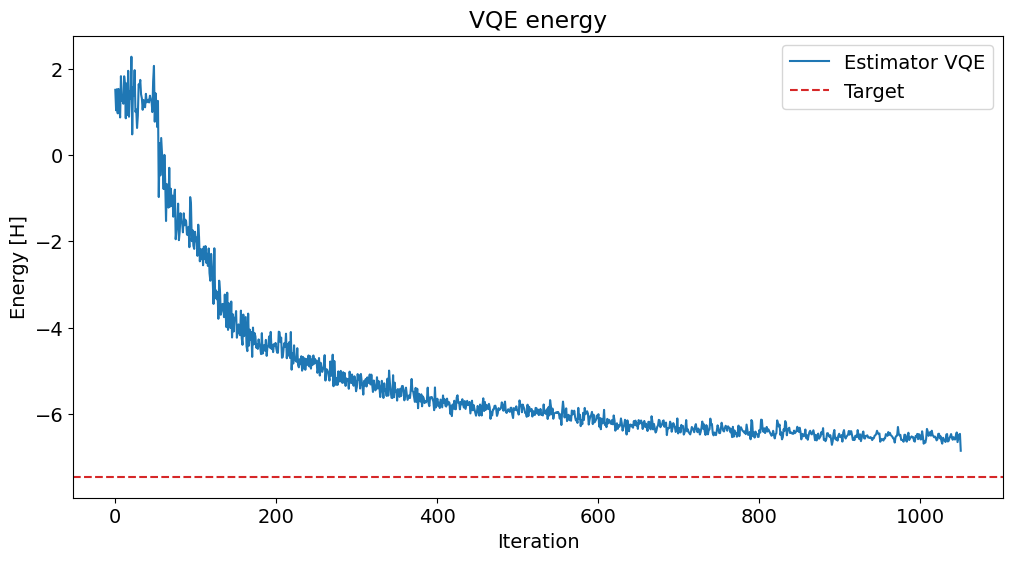

In [13]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=e_gs, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

## 1.2 - Ansatz expressibility

This method has several aspects that can be tuned, such as the shape of the ansatz or the optimization algorithm to find the parameters. These are important factors in more elaborate quantum simulations.
To better understand the role of these parameters, re-implement the method to solve the previous problem ($H_{XXZ}$ with $\Delta=-2$) and compare the results obtained with with different combinations of ansatze and classical optimizers.

 - **Ansatz**:
 
   - Alternating single- and two-qubit (controlled-Z) gate layers, with interactions between all qubit pairs in the two-qubit layers;
   - Alternating single- and two-qubit (controlled-Z) gate layers, in which two-qubit gates are applied only between neighbouring qubits.

 - **Optimizers**:
 
   - Simultaneous Perturbation Stochastic Approximation ([SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html));
   - Constrained Optimization By Linear Approximation ([COBYLA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html));
   - Sequential Least SQuares Programming ([SLSQP](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SLSQP.html)).

For both types of ansatze above, fix only 3 layers of each type of gate. Compare the 6 different combinations of ansatz and optimizer to understand which one performs better both in terms of the accuracy error obtained, and the time and number of steps to converge.

### Plot the estimate of the GS energy as a function of the optimization steps for all the combinations of optimizer and ansatz listed above.

In [15]:
reps = 3

circular_ansatz = TwoLocal(num_qubits, ["ry"], "cz", entanglement="circular", reps=reps).decompose()
full_ansatz = TwoLocal(num_qubits, ["ry"], "cz", entanglement="full", reps=reps).decompose()

In [27]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP

# maxiter = 1000

spsa_optimizer = SPSA(500)
cobyla_optimizer = COBYLA(1000)
slsqp_optimizer = SLSQP(50)

In [28]:
np.random.seed(1)
initial_point = np.random.uniform(-np.pi, np.pi, circular_ansatz.num_parameters)

# Circular + SPSA

In [18]:
log_circular_spsa = VQELog([], [])
vqe = VQE(
        Estimator(),
        circular_ansatz,
        spsa_optimizer,
        callback=log_circular_spsa.update,
        initial_point=initial_point,
    )

result_circular_spsa = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_circular_spsa.optimal_value}")

Experiment complete.          
Raw result: -5.7799032625931055


# Circular + COBYLA

In [29]:
log_circular_cobyla = VQELog([], [])
vqe = VQE(
        Estimator(),
        circular_ansatz,
        cobyla_optimizer,
        callback=log_circular_cobyla.update,
        initial_point=initial_point,
    )

result_circular_cobyla = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_circular_cobyla.optimal_value}")

Experiment complete.          
Raw result: -7.108111801936275


# Circular + SLSQP

In [20]:
log_circular_slsqp = VQELog([], [])
vqe = VQE(
        Estimator(),
        circular_ansatz,
        slsqp_optimizer,
        callback=log_circular_slsqp.update,
        initial_point=initial_point,
    )

result_circular_slsqp = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_circular_slsqp.optimal_value}")

Experiment complete.          
Raw result: -7.143168669175897


# Full + SPSA

In [23]:
log_full_spsa = VQELog([], [])
vqe = VQE(
        Estimator(),
        full_ansatz,
        spsa_optimizer,
        callback=log_full_spsa.update,
        initial_point=initial_point,
    )

result_full_spsa = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_full_spsa.optimal_value}")

Experiment complete.          
Raw result: -5.931277664729282


# Full + COBYLA

In [32]:
log_full_cobyla = VQELog([], [])
vqe = VQE(
        Estimator(),
        full_ansatz,
        cobyla_optimizer,
        callback=log_full_cobyla.update,
        initial_point=initial_point,
    )

result_full_cobyla = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_full_cobyla.optimal_value}")

Experiment complete.          
Raw result: -6.143707148437067


In [25]:
log_full_slsqp = VQELog([], [])
vqe = VQE(
        Estimator(),
        full_ansatz,
        slsqp_optimizer,
        callback=log_full_slsqp.update,
        initial_point=initial_point,
    )

result_full_slsqp = vqe.compute_minimum_eigenvalue(observables)
print("Experiment complete.".ljust(30))
print(f"Raw result: {result_full_slsqp.optimal_value}")

Experiment complete.          
Raw result: -6.221346806663496


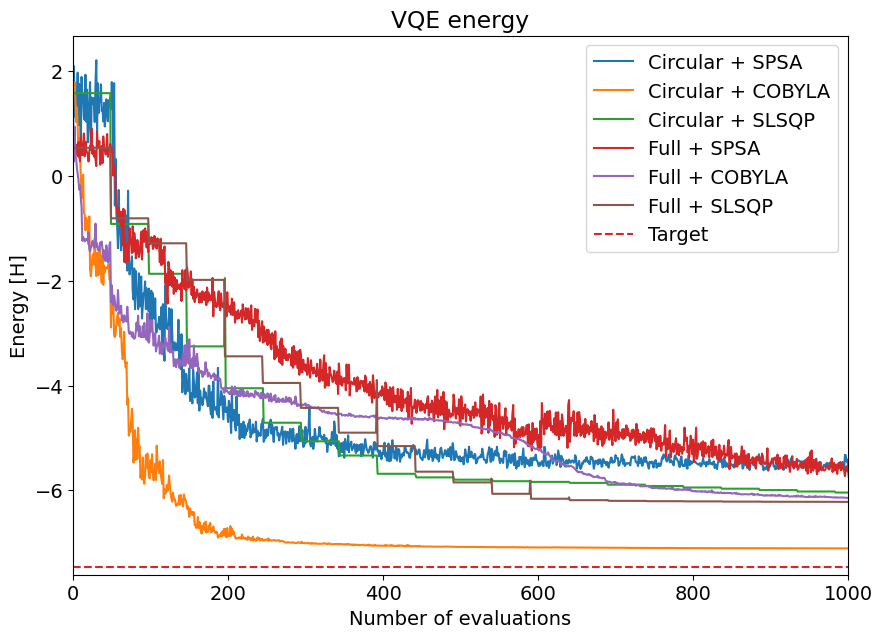

In [37]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(10, 7))
plt.plot(log_circular_spsa.values, label="Circular + SPSA")
plt.plot(log_circular_cobyla.values, label="Circular + COBYLA")
plt.plot(log_circular_slsqp.values, label="Circular + SLSQP")

plt.plot(log_full_spsa.values, label="Full + SPSA")
plt.plot(log_full_cobyla.values, label="Full + COBYLA")
plt.plot(log_full_slsqp.values, label="Full + SLSQP")

plt.axhline(y=e_gs, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Number of evaluations")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.xlim(0, 1000)
# plt.xscale("log")
plt.show()

### It appears that Circular + COBYLA gives the best results.

## 1.3 - Phase diagram

As we have introduced above, the full phase diagram of the $H_{XXZ}$ model encompasses a rich range of behaviours:

- For $\Delta>1$, we have a **ferromagnetic** phase.
- For $-1<\Delta<1$, we have a **paramagnetic** phase.
- For $\Delta\leq-1$, we have an **anti-ferromagnetic** phase.

Use the best combination of optimizer and ansatz that you have found before to prepare the GS of the system for different values of $\Delta$ to reconstruct the phase diagram.
Consider, at least, the values of $\Delta=\{-2, -1, 0, 1, 2\}$.
These will allow you to probe the properties of the GS in each phase.
If you can afford to use more points within the $\Delta\in[-2, 2]$ range, go for it!

Taking the exact solution as a reference, try to improve the ansatz, e.g., adding more layers, to obtain a better representation of the GS of the system.

Once you find the optimal parameters for your best ansatz, use it to compute the expectation value of the **magnetization** of the system along the $z$-axis
$$
M \equiv \frac{1}{2N} \sum_{i=1}^{N} \left\langle \sigma_{i}^{z} \right\rangle\,,
$$
the **staggered magnetization**
$$
M_{st} \equiv \frac{1}{2N}\sum_{i=1}^N (-1)^i\left\langle\sigma_i^z\right\rangle\,,
$$
as well as the expectation value of the **nearest neighbour correlator**
$$
C \equiv \frac{1}{4N} \sum_{i=1}^{N}\left\langle \sigma_{i}^{z} \sigma_{i+1}^{z}  \right\rangle\,.
$$
Plot these observables as a function of $\Delta$.
You will need to prepare the GS multiple times to estimate these averages from the measurement statistics.

### Plot $M$, $M_{st}$ and $C$ as a function of $\Delta$ and comment on the GS properties you can infer from these observables.
> Tip: If you find degenerate GSs, you can compute the expectation values above with only one of them (manually break the symmetry).
Alternatively, you can try to energetically favour one of those by adding an external magnetic field in one direction in the Hamiltonian $H_{XXZ} + \delta\sigma_0^z$ with small $\delta$.

_Having characterized the security system's board material, your breaching expert proceeds to hack it by driving it through the different phases at convenience._

_Congratulations, you've overcome the first challenge!_

----
_The main gate opens and you get a first glimpse of the core's control room.
Apparently, they were conducting research on cleaner nuclear energy.
A novel purpose, although it's now about to wipe us all clean._

_The core is shielded with a shell of lithium hydrate (LiH).
However, the nuclear reaction is going wild and it's destabilizing the shell.
The radiation coming from the core has heated the LiH and excited its electrons, which interferes with the diagnosis system.
If you knew the electronic structure of the material, you could bring the excited electrons down to their low-lying states through stimulated emission._

# 2. FERMIONS IN EXCITED STATES: THE LITHIUM HYDRATE MOLECULE  <a class="anchor" id="2"></a> [[↑]](#0)

_You're packing the quantum computer, when Seedis starts taking it out again.
"Alright mates, we've got plenty of lasers around.
Let's figure out the spectrum of the shell and we can surely point at it some of them to hold it together"._

> Molecular compounds are extremely valuable for our society, as they are central in material sciences and medicine.
Here, we study the electronic properties of the LiH ionic conductor.
Actually, we use different isotopes of LiH to shield and moderate nuclear reactors, but we take this little licence here :)

The goal is to study the electronic structure of the lithium hydrate (LiH) molecule.
The energies in the reactor are so high that the molecules are being distorted.
Therefore, we wish to know the dependence of the low-lying excited states with the interatomic distance. 

The particles we consider (electrons) are fermions.
These are different in nature from the qubits we have access to.
Thus, we need to map the fermionic Hamiltonian to qubits.
To give an intuition, we can relate our qubit states, $|0\rangle$ and $|1\rangle$, with the occupation of the molecule's electronic orbitals, e.g. we can mark occupied orbitals with a $|1\rangle$.
Here, consider the minimal basis set of spin orbitals STO-3G.

When we study these physical systems, we need to take into account that our molecules have a fixed number of electrons that move along the orbitals.
This means we can only consider states with a fixed amount of qubits in state $|1\rangle$, as changing orbitals will replace $|0\rangle$ by $|1\rangle$ in the destination and $|1\rangle$ by $|0\rangle$ at the origin.
For example, Li has three electrons and H has one, meaning that our states must always have four qubits in state $|1\rangle$.
Properly encoding this in our variational ansatze will be essential to find good results.

> Tip: to ease the calculations, restrict the active space by freezing the core orbitals. 
Furthermore, you can exploit the symmetries in the resulting Hamiltonian to reduce the number of qubits.
This does not look like a lot, but it'll surely help ;)

## 2.1 - Molecular spectra

To warm up, find the GS energy of the LiH molecule considering a bond distance of $2~\unicode{x212B}$.
Use a parity map to map the fermionic Hamiltonian to qubits.
Compute also the energy of the next two excited states.

Find the true values with exact diagonalization and compare them with the results obtained through VQE (the closer, the better!).
To obtain the excited states, you can use any extension of the VQE you want, e.g., variational quantum deflation [[Ref.3]](#REF)<a class="anchor" id="Ref3"></a>.

Use a suitable optimizer and a particle-preserving ansatz.

### Compute the energy of the GS and the two first excited states and compare them with the exact results.

## 2.2 - Spectrum as function of the bond length

Compute the the GS and the first two excited states energies as function of the bond length.
Consider bond lengths in a range of $0.5~\unicode{x212B}$ and $2.5~\unicode{x212B}$ in intervals of $0.25~\unicode{x212B}$.

Compare the exact energies with those obtained through variational methods.

### Compute the energy of the GS and the next two excited states as function of the bond length. Can you (roughly) identify a candidate for the equilibrium bond length of the molecule?

## 2.3 - Imperfect devices

In the current noisy intermediate-scale quantum (NISQ) devices, the operations are imperfect and the errors accumulate along the execution of the circuit.
In particular, two-qubit operations, such as the CNOT, have the highest errors.

Here, we consider a more realistic scenario in which we simulate noisy two-qubit gates.
Create a noise model considering an error rate of $0.02$ in CNOT operations.
See the example code below:

```python
from qiskit_aer.noise import NoiseModel, depolarizing_error
noise_model = NoiseModel()
error = depolarizing_error(0.02, 2)
noise_model.add_all_qubit_quantum_error(error, ['cx'])
```

Compute the GS and first excited state energies as function of the bond length with the noisy simulation and compare it with the exact values.

Large circuits with many entangling gates will accumulate many errors, damaging the performance.
Try different ansatze to find the best trade-off between expressivity and errors (even if they do not preserve the particle number).
You can also use other Hamiltonian mappings that may be more convenient for the task.

Report the best results you find and briefly describe your findings (what worked best and what did not).

### Compute the GS and first excited state energies as function of the bond length in the noisy simulation.

_Knowing the electronic properties of the shell, you've managed to stabilize it and cool it a bit in the process.
This has given you some time to work and find a solution._

_We're all slightly less likely to die. Great!_

----

_With the stabilized shell, you can finally run a scanner and obtain a clear diagnosis of the core.
It appears that someone must've momentarily slept on the core moderators, producing a high temperature spike that has caused the LiH from the shell to release hydrogen gas (H$_2$)._

_This has ignited a side fusion reaction of the hydrogen, that further raises the temperature, releasing more H$_2$ to the mixture.
NOT GOOD!
This'll get out of control in a moment.
You must deploy the H collectors (if they work) before this gets out of control!_

_With the apparent mess, the collector memories have been reset.
Given the situation, you feel lucky to even find some functional collectors._ 

# 3. MASTER THE QUANTUM SIMULATION SHENANIGANS  <a class="anchor" id="3"></a> [[↑]](#0)

_Seedis is on a rampage: "Let's go bois and gals, these collectors won't get fixed by themselves! We just need to load the H$_2$ data to stop the retroalimentation loop."_

> It's time to test the power of a real quantum computer.
In this task you will use an actual quantum computer to find the ground state of the H$_2$ molecule. 

Using one of the quantum computers from [IBM Quantum](https://quantum-computing.ibm.com/), find the GS energy of the hydrogen molecule H$_2$ for a bond distance of $0.735~\unicode{x212B}$.
Use all the tools at your disposal to obtain the best possible result and try to make the most efficient use of resources through [Qiskit runtime](https://quantum-computing.ibm.com/lab/docs/iql/runtime/).

We recommend looking carefully at both runtime (the faster, the more you can experiment) and error sources (self-explanatory!).
Here, we provide a few ideas to explore. However, you are not bound to implement any of these, you're completely free to do whatever you want to improve the simulation.

Consider:
- Looking into the hardware architecture to identify the best qubits to use
- Calibrate the qubits with [Qiskit Pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)
- Tailor the ansatz to the hardware
- Implement an adaptive algorithm to reduce the ansatz size
- Implement error mitigation techniques like [measurement error mitigation](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html), [randomized compiling](https://qiskit.org/documentation/stable/0.32/stubs/qiskit.ignis.verification.QOTP.html), and [others](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/Error-Suppression-and-Error-Mitigation.html)
- Parallelize operations and measurements
- Explore [dynamic circuit](https://quantum-computing.ibm.com/services/programs/docs/runtime/manage/systems/dynamic-circuits/Introduction-To-Dynamic-Circuits) techniques
- Explore more advanced optimization schemes (e.g., [Quantum Natural SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html))

## Bonus: an extra atom

If you consider that you have obtained a competitive result for H$_2$, you can tackle the H$_3^+$ molecule. It has the same number of electrons, but you will have to consider more orbitals (which requires more qubits).

The three hydrogen atoms form an equilater triangle with bond length $0.986~\unicode{x212B}$.

_You upload the simulation results to the few functional collectors.
With more faith than expectations, you deploy them to clear the core chamber hoping they will collect enough H$_2$ before they fry._

_Alea iacta est._

_This gives you a brief moment to think about the possible outcomes.
It does not look good, and you look into your teamates eyes.
You feel pure respect and joy to be in such an amazing unit._

_The last collector is down.
Your heart stops for a moment, right before you see the temperature starting to drop.
You did it!
Well, technically you still need to stabilize the core, but the biggest threat has been neutralized.
The rest is just a rutinary protocol._

_Congratulations!
You should all be proud of your hard work during this intense weekend.
It surely was an entertaining crisis to handle!_

## REFERENCES <a class="anchor" id="REF"></a> [[↑]](#0)

[1] Franchini, Fabio. An introduction to integrable techniques for one-dimensional quantum systems. Vol. 940. Cham: Springer International Publishing, 2017. ([url](https://arxiv.org/abs/1609.02100))

[2] Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242-246. ([url](https://arxiv.org/abs/1704.05018))

[3] Higgott, Oscar, Daochen Wang, and Stephen Brierley. "Variational quantum computation of excited states." Quantum 3 (2019): 156. ([url](https://quantum-journal.org/papers/q-2019-07-01-156/))

In [387]:
# pylint: disable=line-too-long
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

C:\Users\thier\AppData\Local\Temp\ipykernel_11764\421762560.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms import (GroundStateEigensolver,
C:\Users\thier\AppData\Local\Temp\ipykernel_11764\421762560.py:3: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms import (GroundStateEigensolver,


In [392]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True,
                               remove_orbitals=[-3,-2])])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

In [393]:
get_qubit_op(2)

MissingOptionalLibraryError: "The 'pyscf' library is required to use 'PySCFDriver'.  See https://pyscf.org/install.html."

In [394]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(dist)
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

MissingOptionalLibraryError: "The 'pyscf' library is required to use 'PySCFDriver'.  See https://pyscf.org/install.html."